# STEP3: SLAT alignment
We use `SLAT` to alignment cells 

In [18]:
import pickle
import time
import matplotlib.pyplot as plt

import scanpy as sc
import numpy as np
import pandas as pd
import torch_geometric
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn import preprocessing

import scSLAT
from scSLAT.model import load_anndatas, Cal_Spatial_Net, run_SLAT, spatial_match
from scSLAT.viz import match_3D_multi, match_3D_multi_error, hist, match_3D_celltype
from scSLAT.metrics import hit_k,region_statistics

In [4]:
sc.set_figure_params(dpi=120)

In [5]:
rna = sc.read_h5ad('./glue_rna-E11_20um.h5ad')
atac = sc.read_h5ad('./glue_atac-E11_20um.h5ad')

# Pre-match

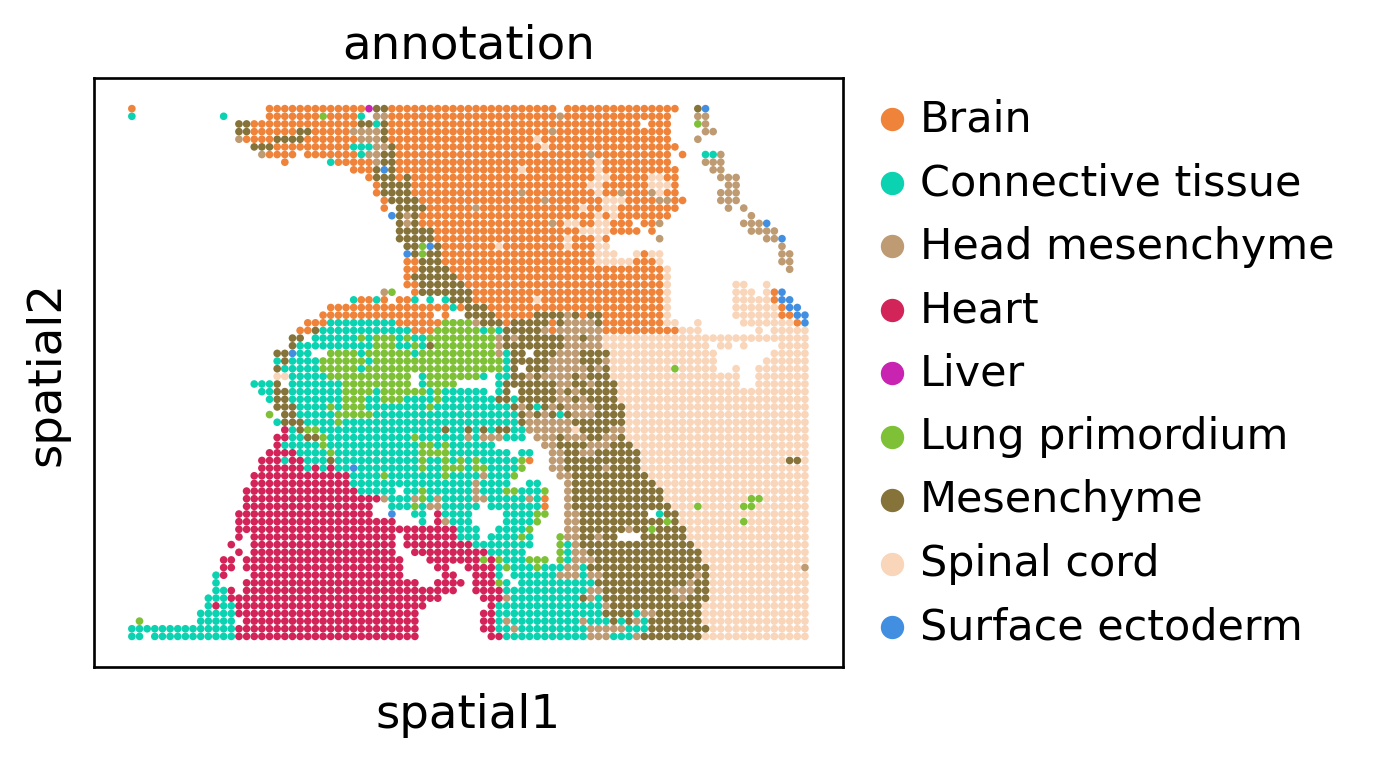

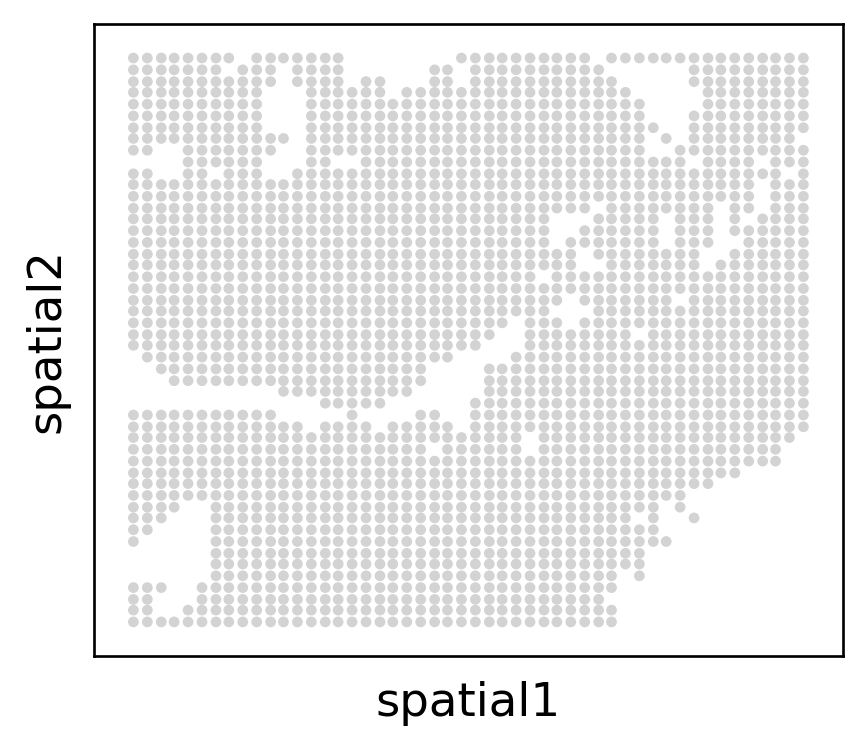

In [6]:
sc.pl.spatial(rna, spot_size=1, color = 'annotation')
sc.pl.spatial(atac, spot_size=10)

In [7]:
atac.obsm['spatial_bak'] = atac.obsm['spatial'].copy()
atac.obsm['spatial'] = np.array([atac.obsm['spatial_bak'][:,0],-atac.obsm['spatial_bak'][:,1]]).T

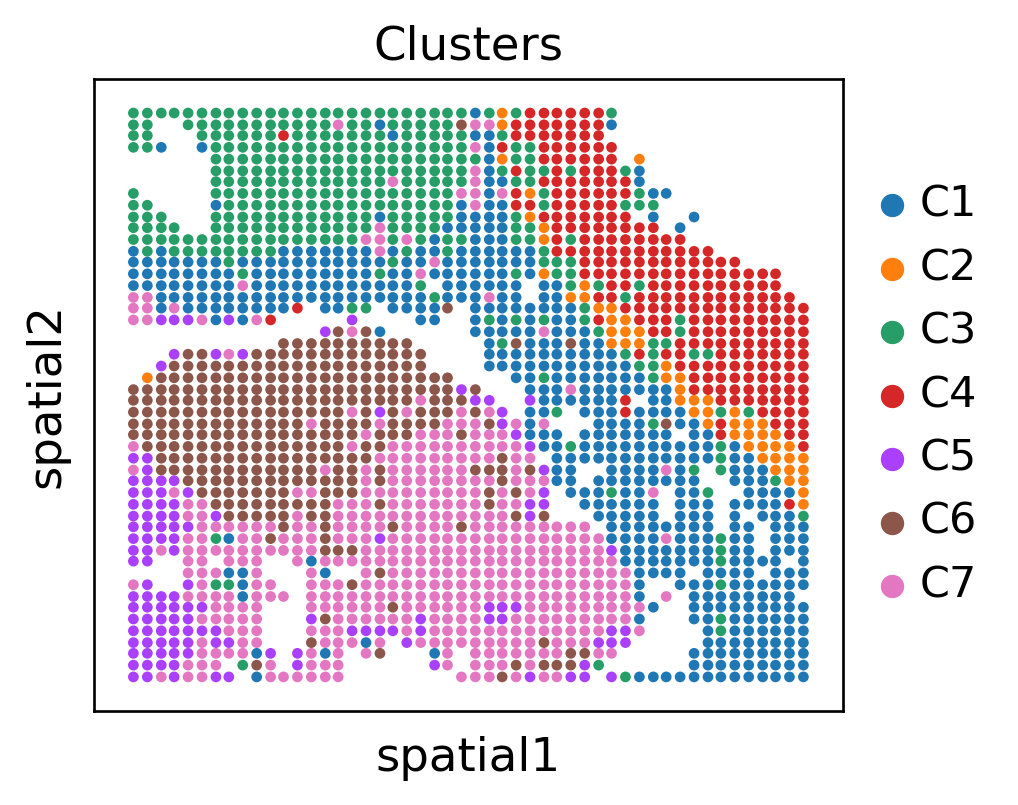

In [8]:
sc.pl.spatial(atac, spot_size=10, color='Clusters')

# run SLAT

In [9]:
Cal_Spatial_Net(rna, k_cutoff=50, model='KNN')
Cal_Spatial_Net(atac, k_cutoff=20, model='KNN')
edges, features = load_anndatas([rna, atac], feature='glue')
embd0, embd1, time = run_SLAT(features,edges,epochs=8)

Calculating spatial neighbour graph ...
The graph contains 206600 edges, 4132 cells.
50.0000 neighbors per cell on average.
Calculating spatial neighbour graph ...
The graph contains 41980 edges, 2099 cells.
20.0000 neighbors per cell on average.
Use glue feature to format graph
Choose GPU:3 as device
Running
---------- epochs: 1 ----------
---------- epochs: 2 ----------
---------- epochs: 3 ----------
---------- epochs: 4 ----------
---------- epochs: 5 ----------
---------- epochs: 6 ----------
---------- epochs: 7 ----------
---------- epochs: 8 ----------
Total Time 0.61


In [10]:
best, index, distance = spatial_match(embd0, embd1, adatas=[rna,atac])

Smoothing mapping, make sure object is in same direction


In [11]:
rna_df = pd.DataFrame({'index':range(embd0.shape[0]),
                          'x': rna.obsm['spatial'][:,0],
                          'y': rna.obsm['spatial'][:,1],
                          'leiden':rna.obs['annotation']})

atac_df = pd.DataFrame({'index':range(embd1.shape[0]),
                          'x': atac.obsm['spatial'][:,0],
                          'y': atac.obsm['spatial'][:,1],
                          'leiden':atac.obs['Clusters']})

matching = np.array([range(best.shape[0]), best])
region_statistics(distance[:,0])

0.500~0.550         0          0.000%
0.550~0.600         0          0.000%
0.600~0.650         3          0.143%
0.650~0.700        15          0.715%
0.700~0.750        43          2.049%
0.750~0.800       186          8.861%
0.800~0.850       351         16.722%
0.850~0.900       737         35.112%
0.900~0.950       708         33.730%
0.950~1.000        56          2.668%


# Vis

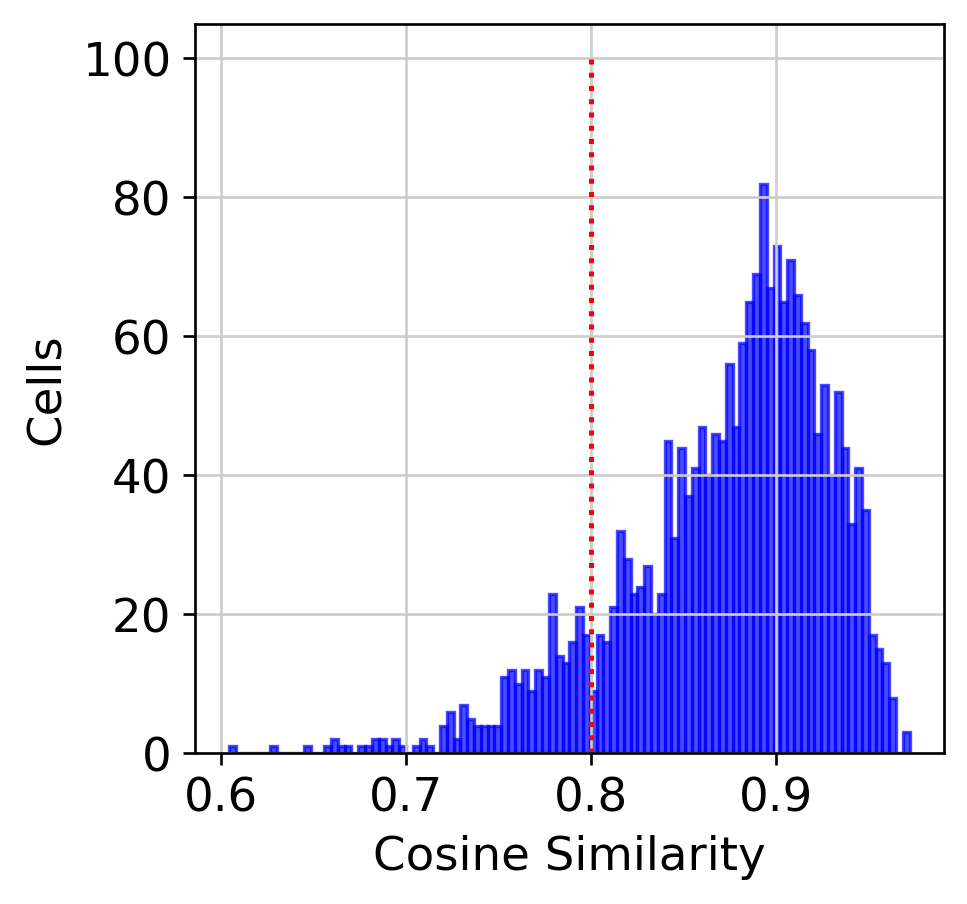

In [12]:
plt.hist(distance[:,0], bins=100, facecolor="blue", edgecolor="blue", alpha=0.7)
plt.vlines(0.8,0,100,color="red",linestyles='dotted',label='0.9')
plt.xlabel(r'Cosine Similarity')
plt.ylabel(r'Cells')
plt.show()

/rd2/user/xiacr/spatialGLUE/conda/lib/python3.8/site-packages/Dragon/viz/multi_dataset.py:231: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.celltypes = set(self.dataset_A[meta].append(self.dataset_B[meta]))


dataset1: 9 cell types; dataset2: 7 cell types; 
                    Total :16 celltypes; Overlap: 0 cell types 
                    Not ovelap :[['Surface ectoderm', 'Lung primordium', 'Head mesenchyme', 'Heart', 'Connective tissue', 'Mesenchyme', 'Liver', 'Brain', 'Spinal cord', 'C3', 'C6', 'C7', 'C5', 'C4', 'C1', 'C2']]
Subsample 300 cell pairs from 2099


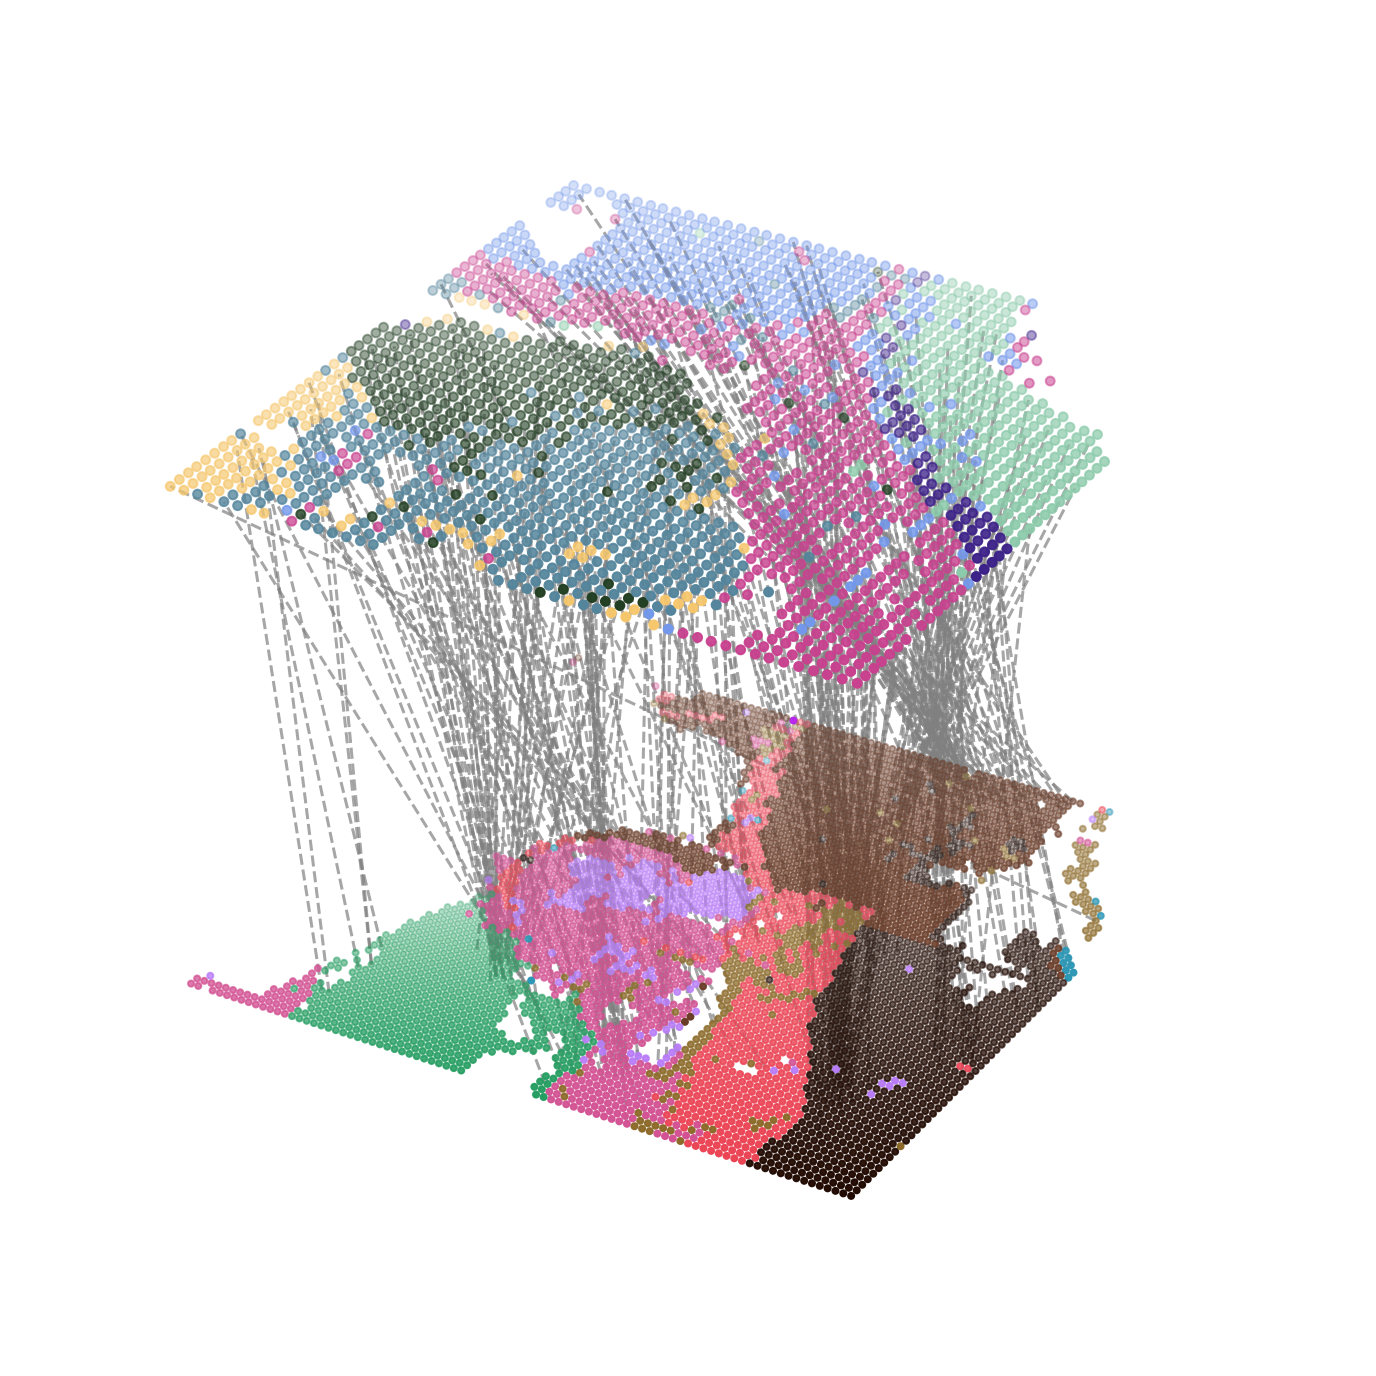

In [13]:
%matplotlib inline
matching_filter = matching[:, distance[:,0] > 0.9]
multi_align = match_3D_multi(rna_df, atac_df,matching,meta='leiden',rotate=['y','y'],
                             scale_coordinate=True,subsample_size=300)

multi_align.draw_3D([12, 12],line_width =1.5,point_size=[9,20], hide_axis=True,show_error=False)

# Cell type label transfer

In [16]:
atac.obs['target_celltype'] = rna_df.iloc[matching[1,:],:]['leiden'].to_list()
atac.obs.target_celltype.value_counts()

Brain                617
Spinal cord          454
Connective tissue    366
Heart                332
Head mesenchyme      151
Mesenchyme           125
Lung primordium       37
Surface ectoderm      16
Liver                  1
Name: target_celltype, dtype: int64

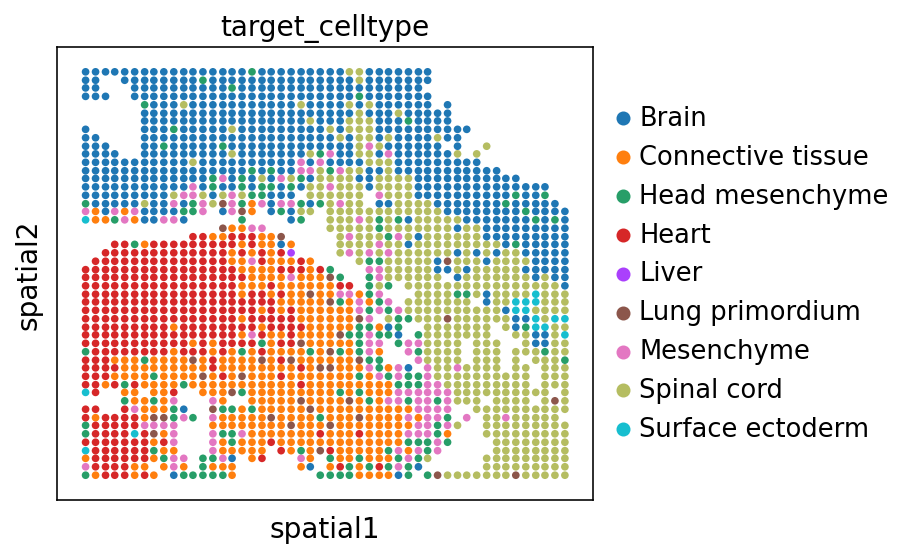

In [17]:
sc.pl.spatial(atac, spot_size=10, color='target_celltype')

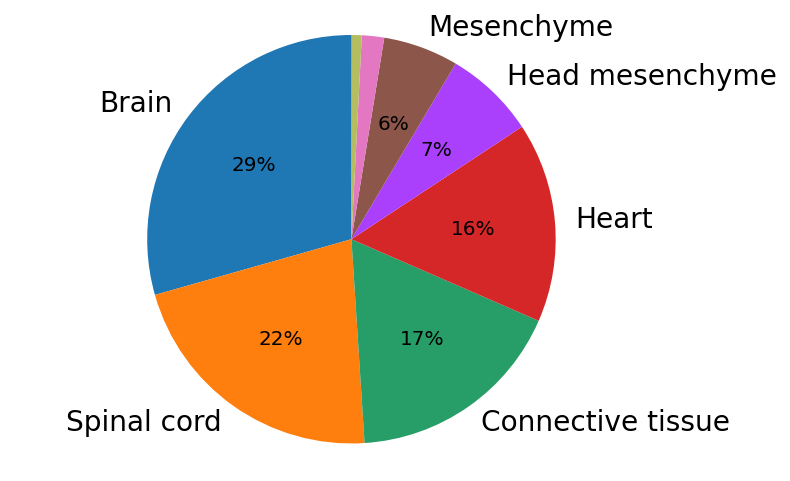

In [19]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels =  atac.obs.target_celltype.value_counts().index.values
sizes = atac.obs.target_celltype.value_counts().values
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
labels = [n if v > sizes.sum() * 0.03 else '' for n, v in zip(labels, sizes)]  

def autopct_more_than_1(pct):
    return ('%1.f%%' % pct) if pct > 3 else ''

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct=autopct_more_than_1,
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [21]:
atac.obs.to_csv('./SLAT_anno.csv')

# Gene expr match check

In [23]:
atac_score = pd.read_csv('./ArchR_impute_score.csv', index_col=0).T

In [26]:
atac.obs.head()

barcode  suffix  x1  x2   p1    p2                      Barcodes  \
0  ATTGAGGAACGCTCGA       1  20  28  746   903  ME11_20um#ATTGAGGAACGCTCGA-1   
1  AAGACGGAAGAGTCAA       1  23  15  784  1042  ME11_20um#AAGACGGAAGAGTCAA-1   
2  GAATCTGAATCCTGTA       1  27  45  835   720  ME11_20um#GAATCTGAATCCTGTA-1   
3  CCGAAGTAGACTAGTA       1  30  36  874   817  ME11_20um#CCGAAGTAGACTAGTA-1   
4  CCGAAGTACCAGTTCA       1  35  36  937   817  ME11_20um#CCGAAGTACCAGTTCA-1   

      Sample  TSSEnrichment  ReadsInTSS  ...  nMonoFrags  nFrags  nDiFrags  \
0  ME11_20um          6.028        1586  ...       25433   45833     13074   
1  ME11_20um          3.049         562  ...       33026   58300     14989   
2  ME11_20um          5.508        1488  ...       21488   40520     12200   
3  ME11_20um          5.520        1221  ...       22644   40743     11505   
4  ME11_20um          2.435         300  ...       16695   30088      7683   

   BlacklistRatio  Clusters      Barcodes_cut  leiden  balancing_weight  \
0        0.020269        C6  ATTGAGGAACGCTCGA       0          0.513772   
1        0.036509        C1  AAGACGGAAGAGTCAA       1          1.298317   
2        0.019003        C7  GAATCTGAATCCTGTA       0          1.297712   
3        0.020433        C7  CCGAAGTAGACTAGTA       0          0.948839   
4        0.028466        C1  CCGAAGTACCAGTTCA       0          0.783331   

   domain    target_celltype  
0    atac  Connective tissue  
1    atac        Spinal cord  
2    atac  Connective tissue  
3    atac    Head mesenchyme  
4    atac         Mesenchyme  

[5 rows x 26 columns]

In [27]:
atac_score['barcodes'] = atac_score.index.str.split('-').str[0].str.split('#').str[1]
obs = atac.obs.merge(atac_score,right_on='barcodes', left_on='barcode',suffixes=None)
obs.index = obs.barcode
atac.obs = obs

/tmp/ipykernel_1552250/2873350300.py:2: FutureWarning: Passing 'suffixes' as a <class 'NoneType'>, is not supported and may give unexpected results. Provide 'suffixes' as a tuple instead. In the future a 'TypeError' will be raised.
  obs = atac.obs.merge(atac_score,right_on='barcodes', left_on='barcode',suffixes=None)


In [114]:
atac_df['Tnnt2'] = sc.get.obs_df(atac, 'Tnnt2').values
rna_df['Tnnt2'] = sc.get.obs_df(rna, 'Tnnt2').values

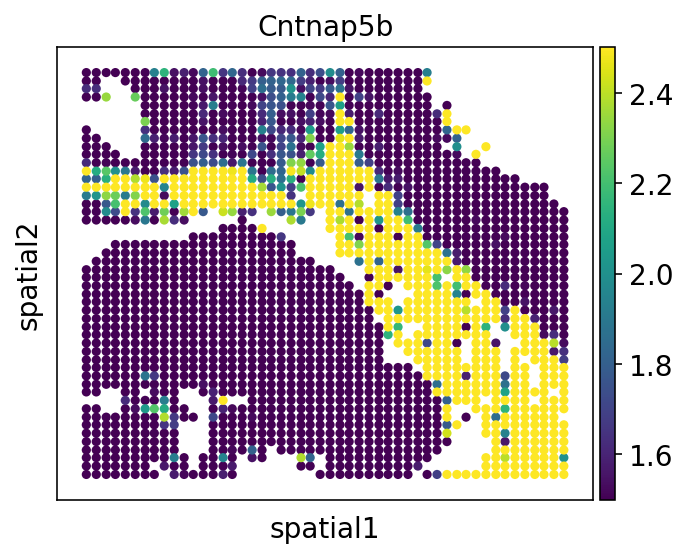

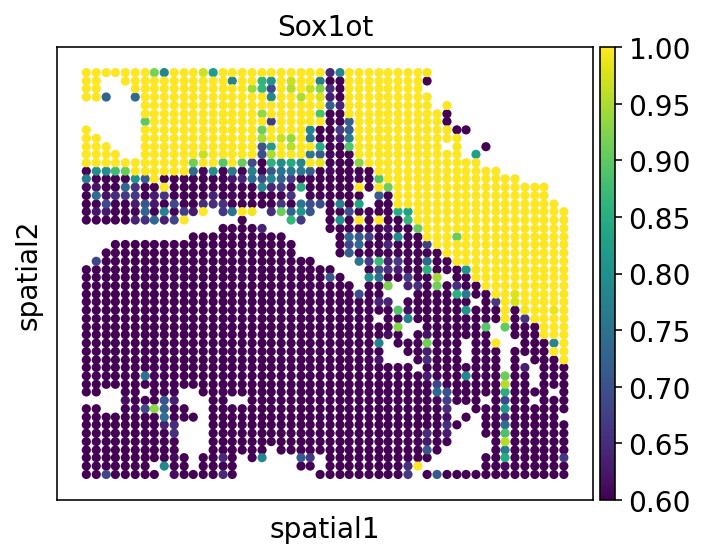

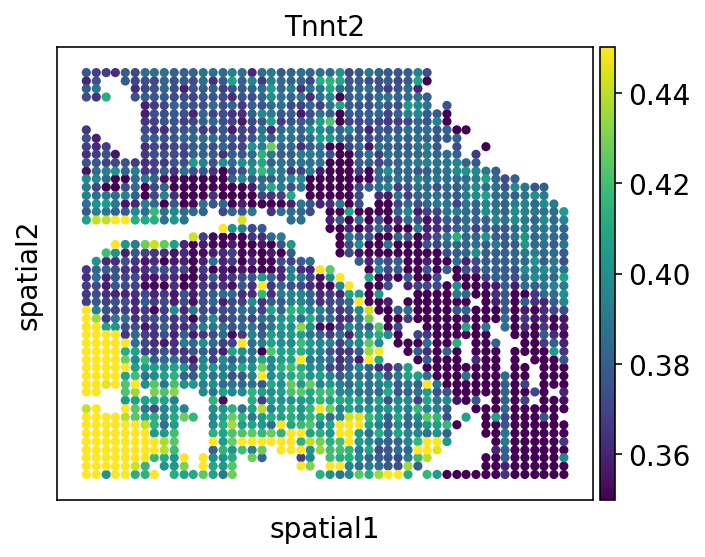

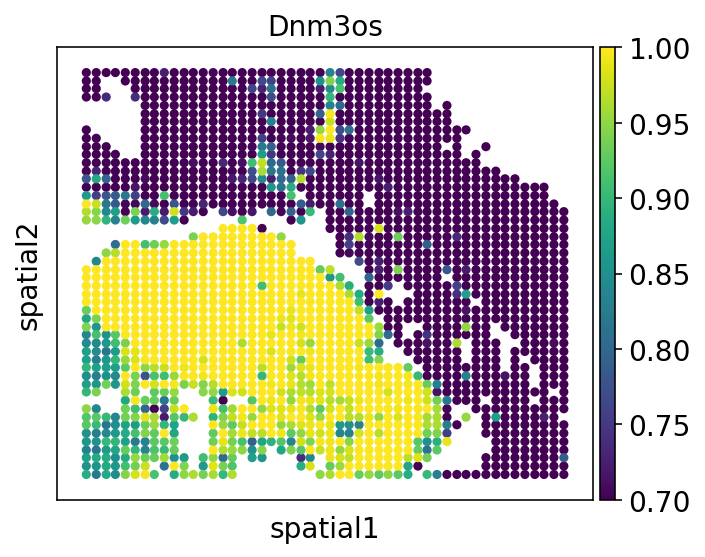

In [30]:
sc.pl.spatial(atac, spot_size=12, color=['Cntnap5b'],vmin=1.5, vmax=2.5)
sc.pl.spatial(atac, spot_size=12, color=['Sox1ot'],vmin=0.6, vmax=1.0)
sc.pl.spatial(atac, spot_size=12, color=['Tnnt2'],vmin=0.35, vmax=0.45)
sc.pl.spatial(atac, spot_size=12, color=['Dnm3os'],vmin=0.7, vmax=1.0)

In [ ]:
sc.pl.spatial(atac, spot_size=12, color='Stmn2', vmax = 0.5)
sc.pl.spatial(atac, spot_size=12, color='Dcx', vmax = 0.3)
sc.pl.spatial(atac, spot_size=12, color='Map2',vmin=0.8, vmax = 1)
sc.pl.spatial(atac, spot_size=12, color='Myl3',vmin=0.45, vmax = 0.55)

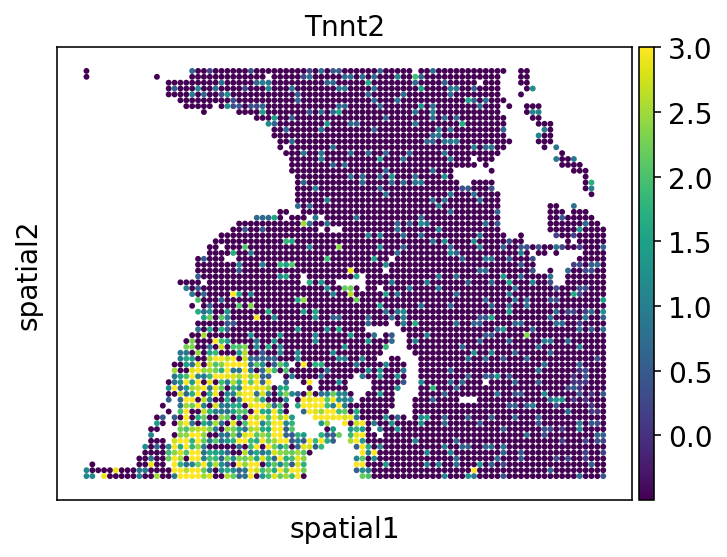

In [31]:
sc.pl.spatial(rna, spot_size=1, color='Tnnt2', vmax = 3)

/tmp/ipykernel_3468948/1946429057.py:231: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.celltypes = set(self.dataset_A[meta].append(self.dataset_B[meta]))


dataset1: 9 cell types; dataset2: 7 cell types; 
                    All :16 celltypes; Overlap: 0 cell types 
                    Not ovelap :[['Heart', 'Liver', 'Connective tissue', 'Brain', 'Head mesenchyme', 'Mesenchyme', 'Lung primordium', 'Surface ectoderm', 'Spinal cord', 'C6', 'C1', 'C5', 'C4', 'C7', 'C2', 'C3']]
Just subsample 773 cell pairs from 774


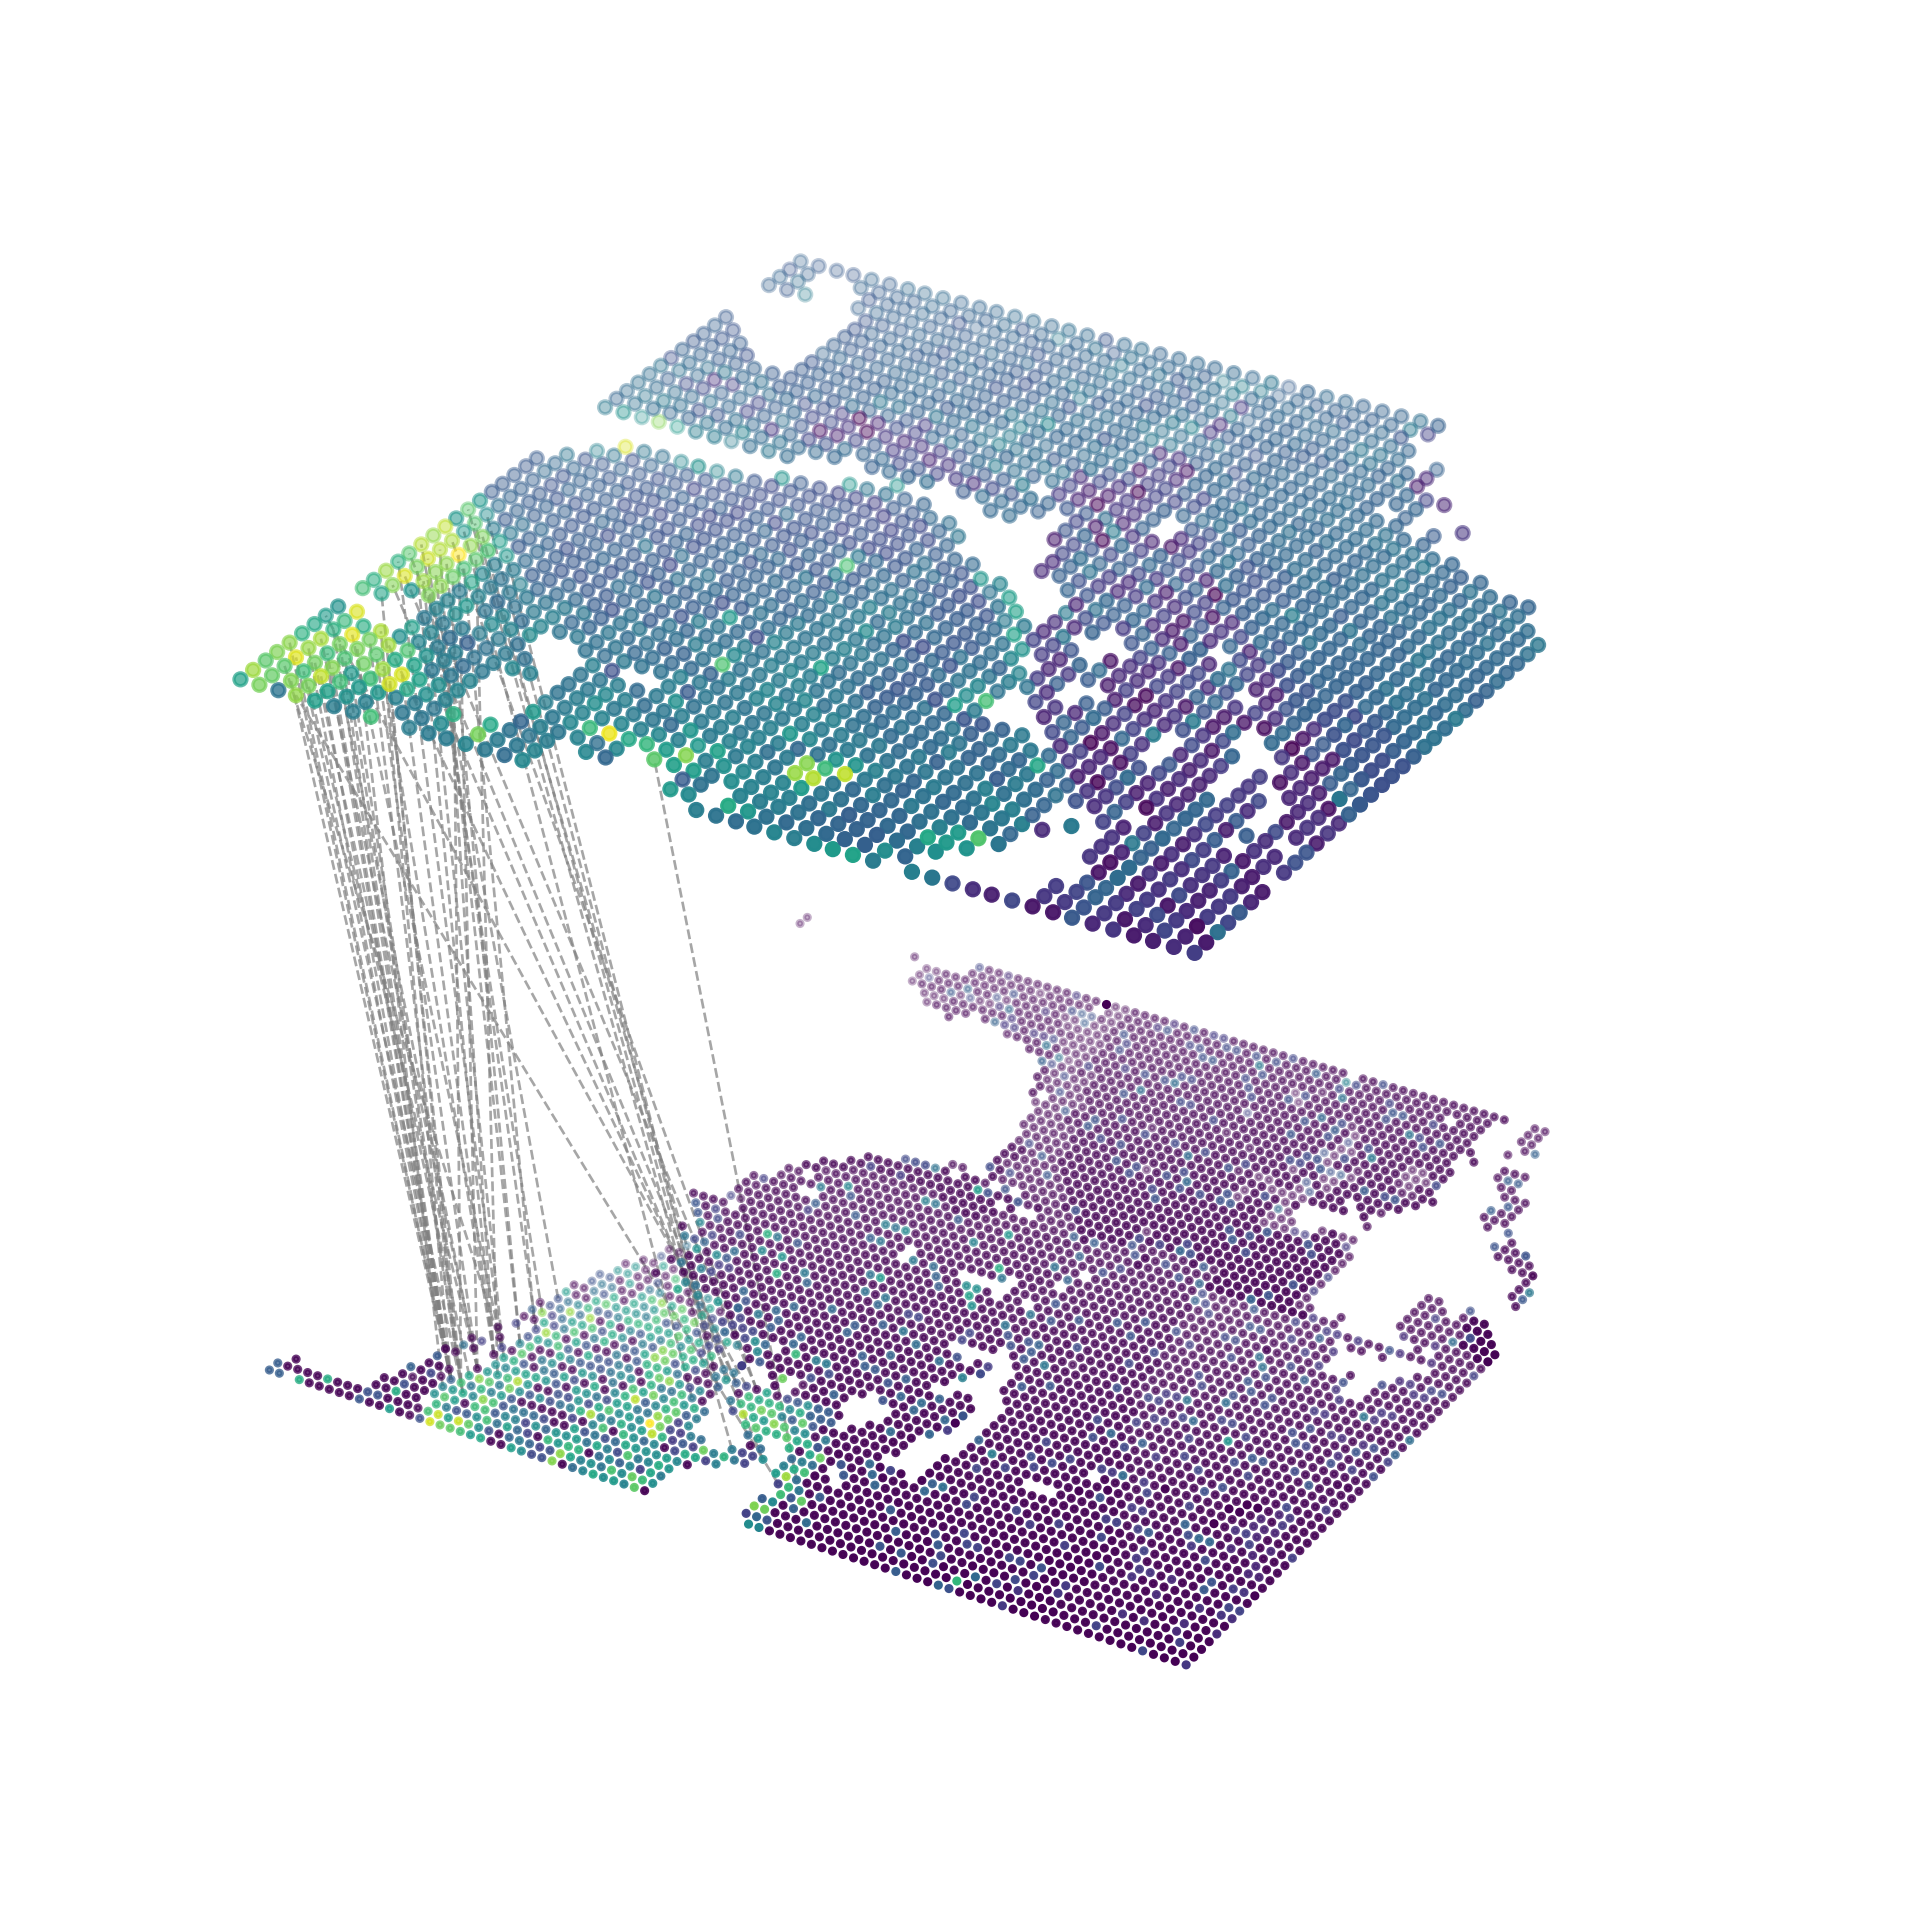

In [206]:
test = match_3D_celltype(rna_df, atac_df, matching_filter, meta='leiden', highlight_celltype=[['Heart'],['C5']], expr='Tnnt2',rotate=['y','y'],
                         subsample_size=matching_filter.shape[1]-1, scale_coordinate=True)
test.draw_3D(size=[10, 12],line_width=0.8,point_size=[3,15], hide_axis=True, cmap='viridis', show_error=False)

# Prepare for SCENIC+

In [131]:
matching_filter_0_8 =  matching[:, distance[:,0] > 0.8]

In [134]:
atac_filter = atac[matching_filter_0_8[0,:],:]
rna_filter = rna[matching_filter_0_8[1,:],:]

In [147]:
atac_filter.obs = atac_filter.obs.iloc[:,0:25]

In [156]:
atac_filter.obs.index = atac_filter.obs.index + '-1'

In [159]:
rna_filter.obs.index = atac_filter.obs.index

In [160]:
atac_filter.write_h5ad('./scenicplus/data/atac_filter.h5ad')
rna_filter.write_h5ad('./scenicplus/data/rna_filter.h5ad')